# K-means algorithm

## Unsupervised machine learning : Clustering

### Reading the data
First we need to open the file containing the data we will be working on.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

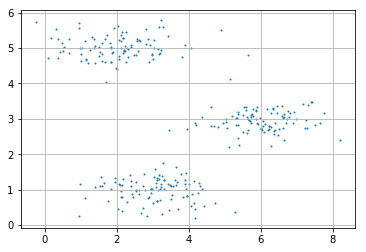

In [2]:
data = np.genfromtxt("data_kmeans.txt", delimiter=' ')

plt.scatter(data[:, 0], data[:, 1], s=1)
plt.grid()

## Clustering

### Define random starting locations

In [32]:
def initialize_cluster_centroids(data, n):
    """
    This function will return a list of n randomly initialized cluster centroids.
    """
    centroids = np.random.rand(n, data.shape[1])
    
    # We want the centroids to be initialized randomly in the range of the input data.
    # figure out the min and max on each axis
    minis = np.array([np.min(data[:, i]) for i in range(data.shape[1])])
    maxis = np.array([np.max(data[:, i]) for i in range(data.shape[1])])
    
    # Now we adjust centroids to be included in the same range the points are
    #centroids *= [mx - mn for mx, mn in zip(maxis, minis)]
    centroids *= maxis - minis
    centroids += minis
    
    return centroids

In [33]:
cluster_centroids = initialize_cluster_centroids(data, 3)

print(cluster_centroids)

[[7.33458607 2.84132607]
 [3.56793614 1.34677466]
 [8.02975668 3.38210439]]


### For each point, find to what cluster it "belongs to"

In [5]:
def compute_distances(point, cluster_centroids):
    """
    Return a list of distances for each point 
    """
    distances = np.zeros(cluster_centroids.shape[0])
    
    for i, cluster in enumerate(cluster_centroids):
        distances[i] = np.power(np.sum(np.power(point - cluster, 2)) , 1/2)
        
    return distances

def return_closest(data, cluster_centroids):
    """
    Return numpy array of size equal to number of points. It indicates,
    for each point, what center that point is closest to.
    """
    proximities = np.zeros(data.shape[0])
    
    distances = np.apply_along_axis(compute_distances, 1, data, cluster_centroids)
    
    closest = np.argmin(distances, axis=1)
    
    return closest

In [6]:
closest = return_closest(data, cluster_centroids)

print(closest)
print(np.unique(closest))

[0 1 1 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 2 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 2 2 2 0 0 0 1 0 0 0 2 0 0 0 2 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2]
[0 1 2]


### Now we find the center of mass of all the points that belong to the same centroid

In [7]:
def compute_new_centroids(data, closest_list, n_centroid):
    """
    This function takes the data points and the closest array.
    - Data : coordinates of all the points in the dataset
    - Closest : Array of size equal to number of points of data,
    which give for each of them the number of the centroid to which
    it is closest.
    
    Returns :
    - A new list of centroids, where each centroid is the center of mass
    of all the points it is closest to.
    """
    # First step is to find how many centers are present in the closest list
    unique_centroids, counts = np.unique(closest_list, return_counts=True)
    
    corrected_centroids = np.zeros((n_centroid, data.shape[1]))
    
    for i, closest in enumerate(closest_list):
        
        corrected_centroids[closest, :] += data[i, :]
        
    # We find the mass by which to divide each centroid.
    # This mass is equal to the amount of points which belong to this
    # centroid
    for unique_centroid, count in zip(unique_centroids, counts):
        corrected_centroids[unique_centroid] /= count
        
    # Finally we delete the centroids that we don't need anymore
    corrected_centroids = corrected_centroids[unique_centroids]
    
    return corrected_centroids

In [8]:
corrected_centroids = compute_new_centroids(data, closest, 3)

print(corrected_centroids)

[[2.50049446 2.91788887]
 [5.75385085 2.82413814]
 [0.44823714 5.1912    ]]


## Algorithm

We have defined functions for each step of the alogirithm. Now all that remains is to put all of these steps in a loop. We stop the loop when there is no longer any progress being made.

In [16]:
def kmean_algorithm(data, n_clusters):
    """
    This function will return an array giving for each point the centroid it
    belongs to, and therefore the cluster it is in.
    """
    cluster_centroids = initialize_cluster_centroids(data, n_clusters)
    
    centroid_history = [cluster_centroids.copy()]
    
    stabilised = False
    while not stabilised:
        # For each point, find what cluster it belongs to
        closest = return_closest(data, centroid_history[-1])
        # Put the new centroids at the center of mass of their clusters
        cluster_centroids = compute_new_centroids(data, closest, centroid_history[-1].shape[0])
        # Check if there has been any change since previous iteration
        if centroid_history[-1].shape == cluster_centroids.shape:
            if (centroid_history[-1] == cluster_centroids).all():
                # If not, we have converged and can end the loop
                stabilised = True
                return closest, centroid_history
    
        centroid_history.append(cluster_centroids.copy())
        
    return closest, centroid_history

In [34]:
clusters, history = kmean_algorithm(data, 3)

print(clusters)

[0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0]


## Analyze the results

We can print the color of each point

In [11]:
def show_clustered_data(data, clusters, x=0, y=1):
    fig, ax = plt.subplots(figsize=(12, 12))

    colors = ["red", "blue", "green", "black", "cyan", "magenta", "peru"]

    for dat, clust in zip(data, clusters):
        ax.scatter(dat[x], dat[y], c=colors[clust], s=2)

    plt.show()

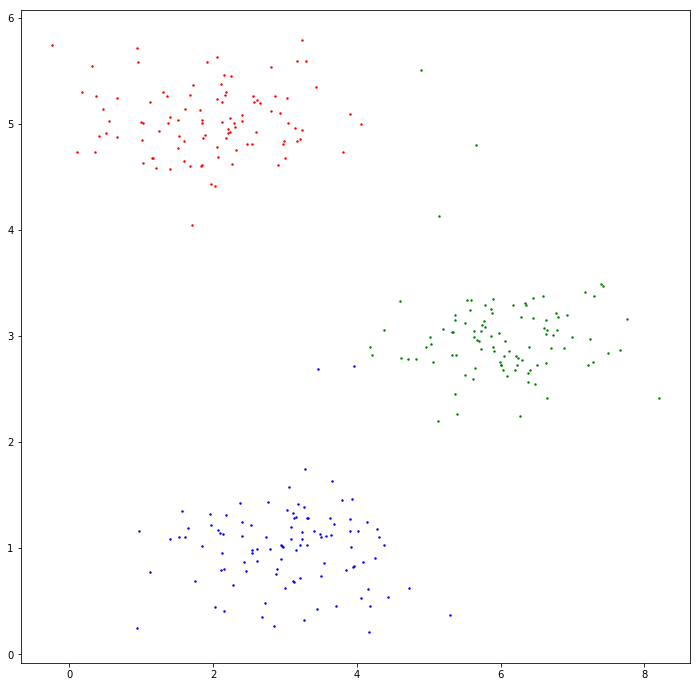

In [26]:
show_clustered_data(data, clusters)

## Apply to some real data

Now we want to apply our algorithm to the "real" dataset.
This dataset is in 6 dimensions, so we won't be able to plot a correct representation of  the clusters. Instead, we show two of the dimensions.

In [35]:
grades = np.genfromtxt("grade_students.csv", delimiter=",", skip_header=1)

grades_clusters, _ = kmean_algorithm(grades, 7)

print(np.unique(grades_clusters).shape[0])

7


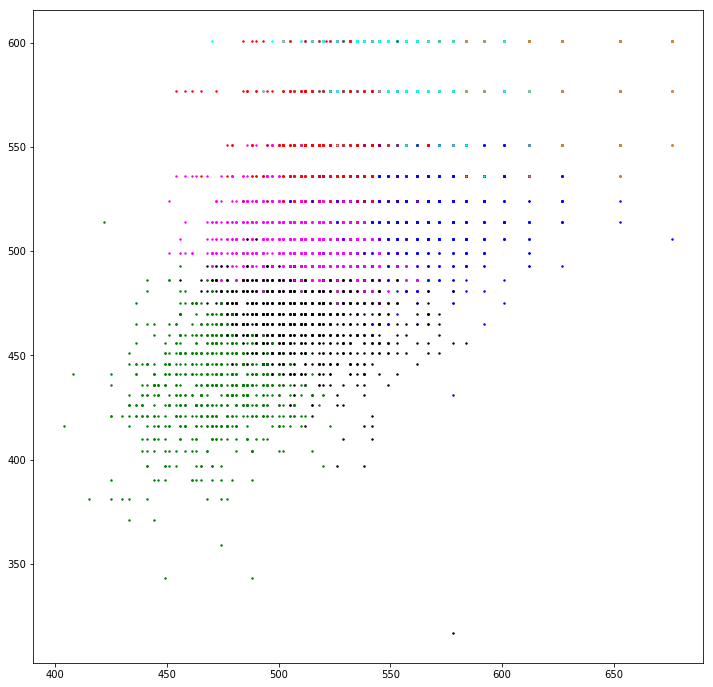

In [36]:
show_clustered_data(grades, grades_clusters, x=3, y=5)